# First Order Generating Function

In this example we demonstrate a basic application of the ``FirstOrderGeneratingFunction`` class. This class is designed to implement canonical perturbation theory calculations using the Lie series formalism. Some background information can be found on the [documentation page](https://celmech.readthedocs.io/en/latest/canonical_transformations.html#lie-series-transformations). We'll use the class to convert between "mean" and "osculating" elements when computing the secular evolution of a pair of planets near (but not in) a 3:2 mean motion resonance.

In [1]:
import numpy as np
import rebound as rb
import sympy as sp
from matplotlib import pyplot as plt
from celmech import Poincare, PoincareHamiltonian
from celmech.lie_transformations import FirstOrderGeneratingFunction

from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits

We begin by initializing a pair of planets with modest eccentricities %3 wide of the 3:2 MMR.

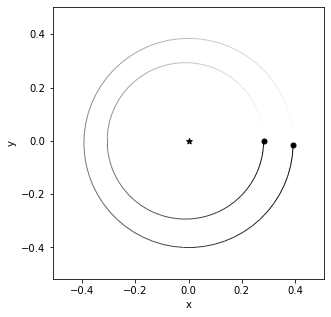

In [2]:
def get_sim():
    sim = rb.Simulation()
    sim.add(m=1)
    sim.add(m=1e-5,P = 1, e=0.04)
    sim.add(m=1e-5,P = (3/2) * ( 1 + .03), e=0.02,pomega = np.pi/2,l=0)
    sim.move_to_com()
    return sim
sim = get_sim()
rb.OrbitPlot(sim);


We'll make two ``PoincareHamiltonian`` models to study the secular evolution of the system. Each model includes the leading order secular terms, while ``pham_full`` also include leading-order 3:2 MMR terms:

In [3]:
pvars_sec, pvars_full = [Poincare.from_Simulation(sim) for _ in range(2)]
pham_sec = PoincareHamiltonian(pvars_sec)
pham_full = PoincareHamiltonian(pvars_full)
for pham in (pham_sec,pham_full):
    pham.add_secular_terms(inclinations=False)
pham_full.add_MMR_terms(3,1)

Now we integrate our models, storing the planets' eccentricities:

In [4]:
from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits
N = 100
Tfin = 200
times = np.linspace(0,Tfin,N)
e_rb,e_cm_sec,e_cm_full = np.zeros((3,2,N))
for i,t in enumerate(times):
    sim.integrate(t)
    pham_full.integrate(t)
    pham_sec.integrate(t)
    orbits = get_canonical_heliocentric_orbits(sim)
    for j,orbit in enumerate(orbits):
        e_rb[j,i] = orbit.e
        e_cm_sec[j,i] = pham_sec.particles[j+1].e
        e_cm_full[j,i] = pham_full.particles[j+1].e

Now we plot the results:

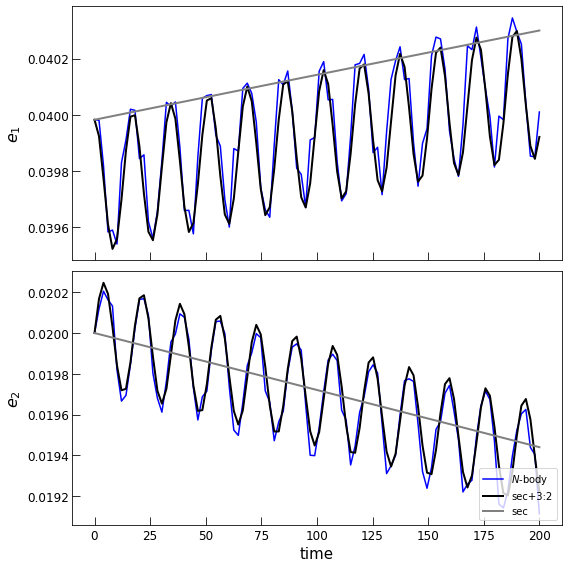

In [5]:
fig,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
for j in range(2):
    plt.sca(ax[j])
    plt.plot(times,e_rb[j],color='blue',label='$N$-body')
    plt.plot(times,e_cm_full[j],color='k',lw=2,label='sec+3:2')
    plt.plot(times,e_cm_sec[j],color='gray',lw=2,label='sec')
    plt.tick_params(labelsize=12,direction='in',size=8)
    plt.ylabel("$e_{}$".format(j+1),fontsize=16)
plt.legend(loc='lower right')
plt.xlabel("time",fontsize=15)
plt.tight_layout()

We see that the purely secular model captures the mean trend of the planets' eccentricities but misses some oscillations caused principally by the nearby 3:2 MMR. Because these oscillations are unaccounted for, the initial values of the eccentricites in the secular model are displaced from the planets' mean eccentricies by an amount on the order of the amplitude of these oscillations.

# Redo secular integration using Lie generating function

We can account for the effects of the nearby 3:2 MMR using Lie series perturbation theory with the  `FirstOrderGeneratingFunction` class. This class implements a near-identity Lie transformation that can eliminate oscillating terms from the Hamiltonian. The user specifies which terms should be eliminated by adding them in the same manner that terms are added to a usual `PoincareHamiltonian` model. 

In our case, we'd like to eliminate the terms associated with the 3:2 MMR, given by:

In [6]:
H_3to2 = pham_full.H - pham_sec.H
H_3to2

                                                               ⎛η₁⋅sin(2⋅λ₁ - 3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                                                                ⎛η₂⋅sin(2⋅λ₁ - 3⋅λ₂)   κ₂⋅cos(2⋅λ₁ -
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── + ─────────────
                                                               ⎜   _______________       _______________ ⎟                                                                ⎜   _______________       __________
                                                               ⎝ ╲╱ \Lambda_{1,0}      ╲╱ \Lambda_{1,0}  ⎠                                                                ⎝ ╲╱ \Lambda_{2,0}      ╲╱ \Lambda_{
- ──────────────────────────────────────────────────────────────────────────────────────────────────────── - ───────────────────────────────────────────────────────────────

We get our generating function object and add terms to the generating function that cancel the effect of the 3:2 MMR terms at first order in planet masses:

In [7]:
pchi = FirstOrderGeneratingFunction(pham_sec.state)
pchi.add_MMR_terms(3,1)
pchi.chi

                                                               ⎛η₁⋅cos(2⋅λ₁ - 3⋅λ₂)   κ₁⋅sin(2⋅λ₁ - 3⋅λ₂)⎞                                                                ⎛η₂⋅cos(2⋅λ₁ - 3⋅λ₂)   κ₂⋅sin(2⋅λ₁ -
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── - ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── - ─────────────
                                                               ⎜   _______________       _______________ ⎟                                                                ⎜   _______________       __________
                                                               ⎝ ╲╱ \Lambda_{1,0}      ╲╱ \Lambda_{1,0}  ⎠                                                                ⎝ ╲╱ \Lambda_{2,0}      ╲╱ \Lambda_{
- ──────────────────────────────────────────────────────────────────────────────────────────────────────── - ───────────────────────────────────────────────────────────────

We can confirm that these terms satisfy $[H_\mathrm{Kep},\chi] + H_{3:2} = 0$ using ``sympy``s symbolic mathematics capabilities:

In [8]:
Hkep = PoincareHamiltonian(Poincare.from_Simulation(sim))
sp.simplify(pchi.Lie_deriv(Hkep.H) + H_3to2)

0

Now we'll reset the state `pham_sec` and redo the integration. In our interation loop we store both the "mean" transformed values and "osculating" un-transformed values by repeatedly applying the Lie transformation and its inverse. The methods `pchi.osculating_to_mean` and `pchi.mean_to_osculating` apply the Lie transformation and its inverse to the values stored by the `pchi.state` attribute, which is the same `Poincare` object stored by `pham_sec.state`. 

In [9]:
# reset pham_sec
pham_sec.state.t=0
pham_sec.state.values = Poincare.from_Simulation(get_sim()).values

In [10]:
N = 100
Tfin = 200
times = np.linspace(0,Tfin,N)
e_sec_mean,e_sec_osc = np.zeros((2,2,N))
for i,t in enumerate(times):
    # convert initial osculating values to mean ones
    pchi.osculating_to_mean()
    pham_sec.integrate(t)
    for j,p in enumerate(pham_sec.particles[1:]):
        e_sec_mean[j,i] = pham_sec.particles[j+1].e
        
    pchi.mean_to_osculating()
    # convert mean back to 
    for j,p in enumerate(pham_sec.particles[1:]):
        e_sec_osc[j,i] = pham_sec.particles[j+1].e

Now our results show better agreement. The divergence between the solutions computed with `pham_sec` and and `pham_full` visible near the end of the integration are due to second- and higher order terms in planet masses. These terms can be important near MMR as shown in the `Laplace-LagrangeSecularTheory.ipynb` example notebook.

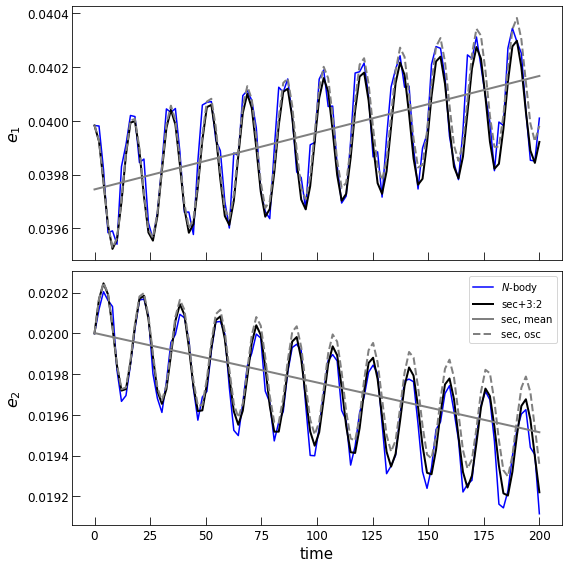

In [11]:
fig,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
for j in range(2):
    plt.sca(ax[j])
    plt.plot(times,e_rb[j],color='blue',label='$N$-body')
    plt.plot(times,e_cm_full[j],color='k',lw=2,label='sec+3:2')
    plt.plot(times,e_sec_mean[j],color='gray',lw=2,label='sec, mean')
    plt.plot(times,e_sec_osc[j],color='gray',lw=2,ls='--',label='sec, osc')
    plt.tick_params(labelsize=12,direction='in',size=8)
    plt.ylabel("$e_{}$".format(j+1),fontsize=16)
plt.legend(loc='upper right')
plt.xlabel("time",fontsize=15)
plt.tight_layout()